  VendorName ModelName  MYCT  MMIN   MMAX  CACH  CHMIN  CHMAX  PRP  ERP
0    adviser     32/60   125   256   6000   256     16    128  198  199
1     amdahl    470v/7    29  8000  32000    32      8     32  269  253
2     amdahl   470v/7a    29  8000  32000    32      8     32  220  253
3     amdahl   470v/7b    29  8000  32000    32      8     32  172  253
4     amdahl   470v/7c    29  8000  16000    32      8     16  132  132
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   VendorName  209 non-null    object
 1   ModelName   209 non-null    object
 2   MYCT        209 non-null    int64 
 3   MMIN        209 non-null    int64 
 4   MMAX        209 non-null    int64 
 5   CACH        209 non-null    int64 
 6   CHMIN       209 non-null    int64 
 7   CHMAX       209 non-null    int64 
 8   PRP         209 non-null    int64 
 9   ERP         209 no

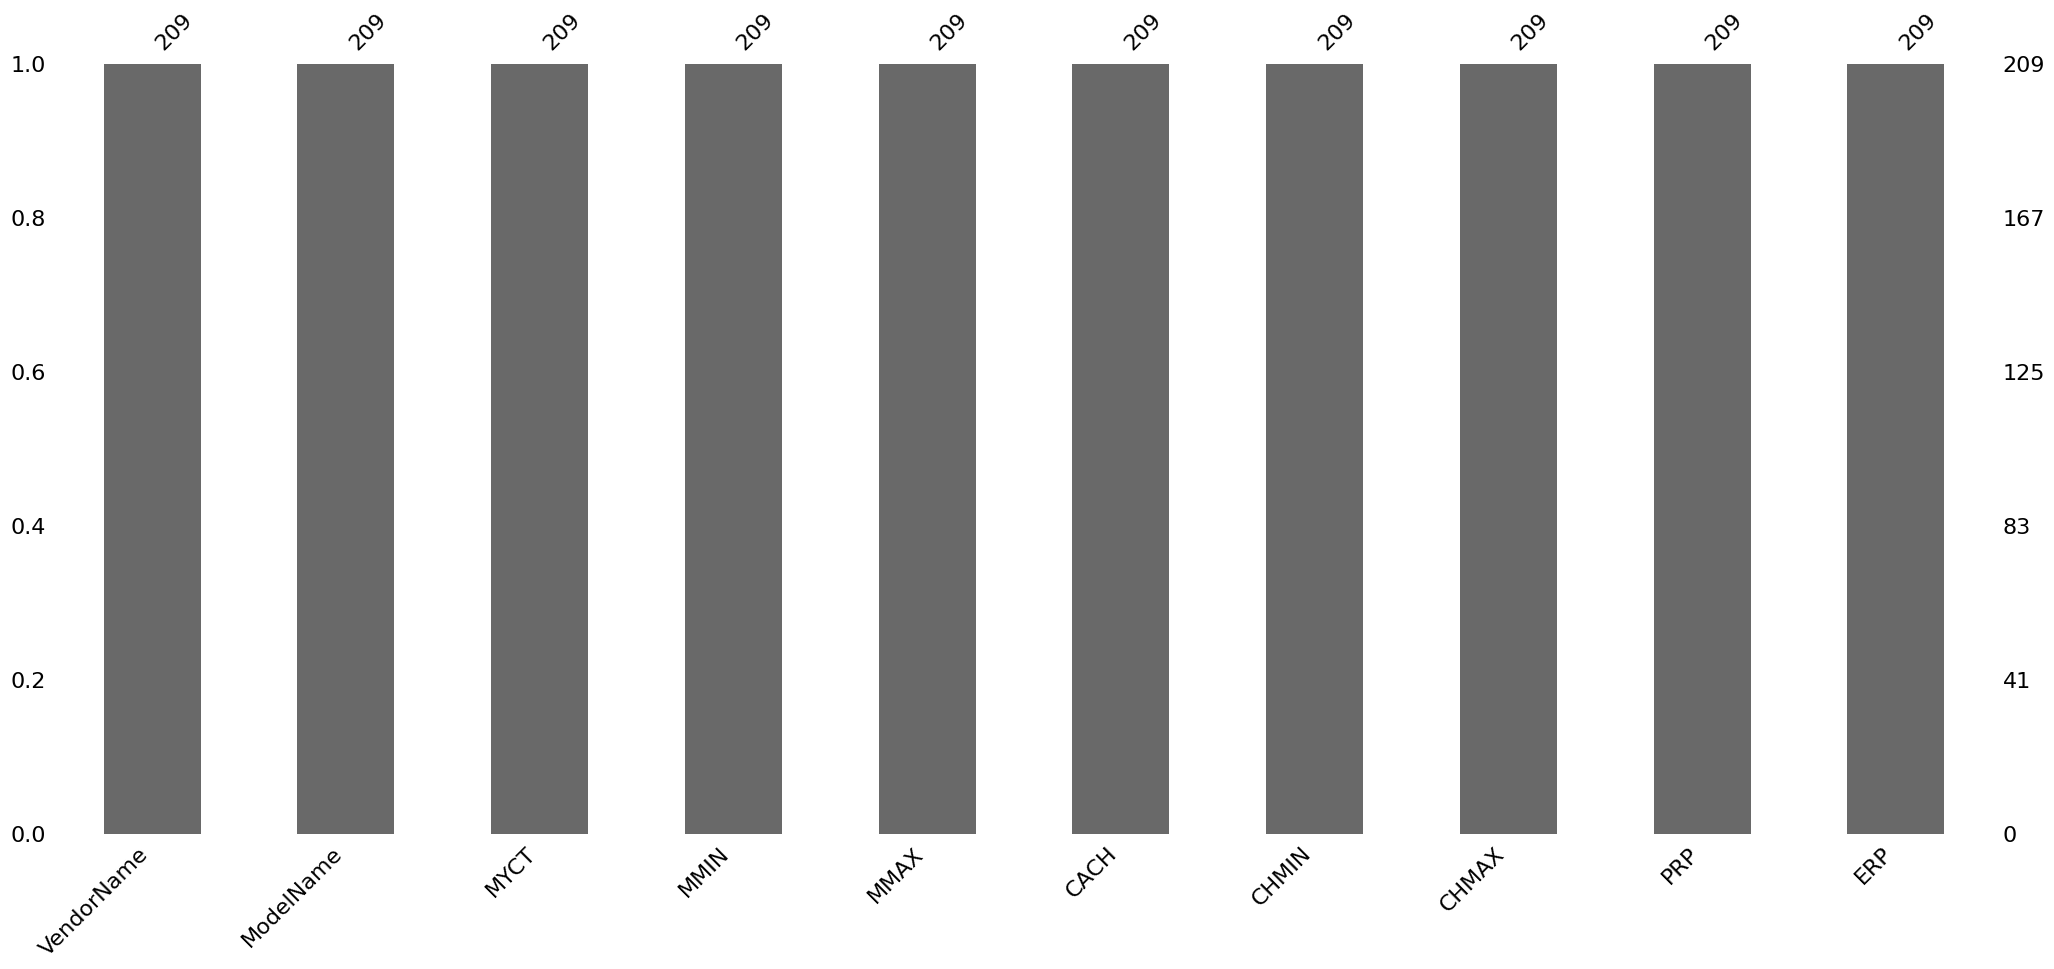

Selected Features: ['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX', 'ERP']
Test MSE: 4379.231956634306
Test MAE: 36.319128064855605
Test R^2: 0.9163641823768056


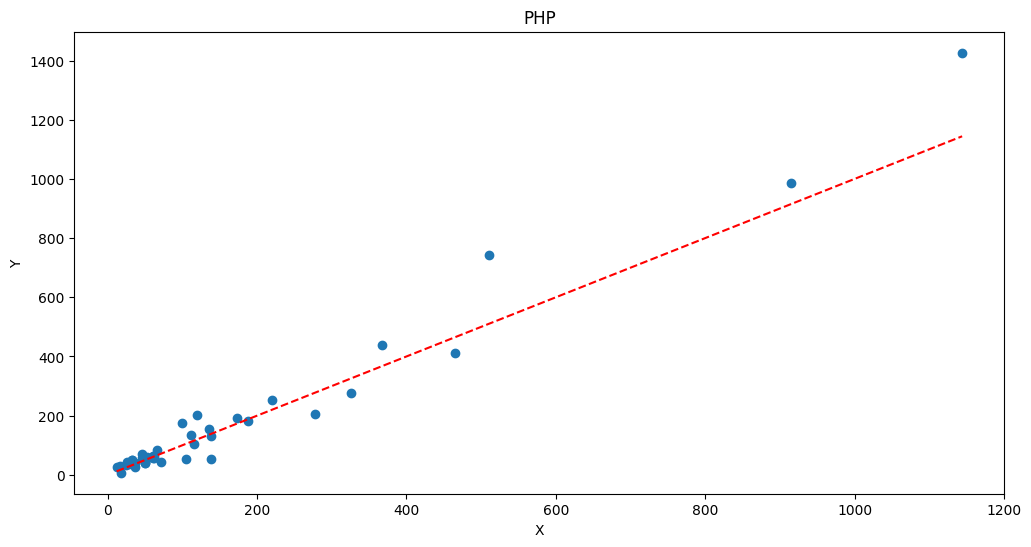

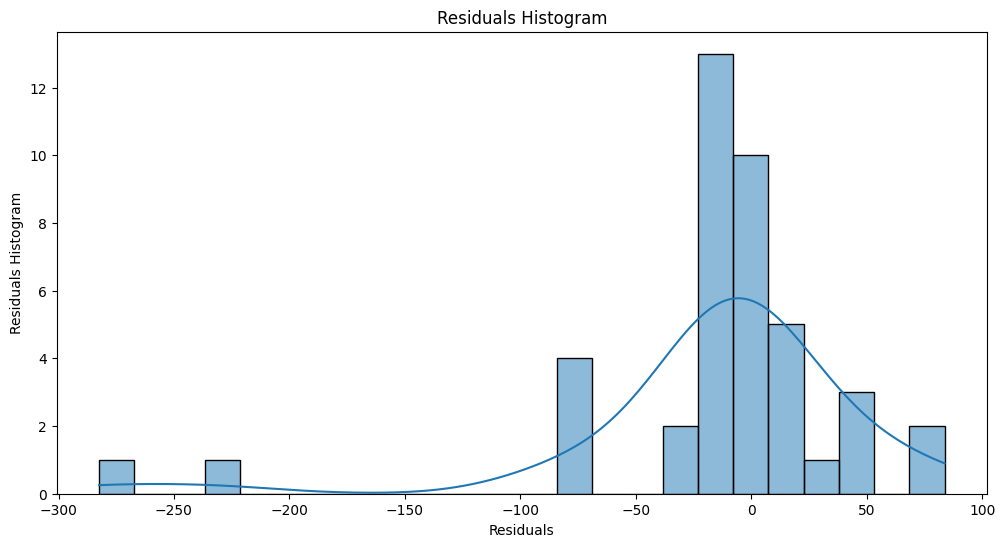

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# 데이터 로드
cpu = pd.read_csv("machine.data_update.csv")

# 데이터 탐색 및 시각화
print(cpu.head())
print(cpu.info())
print(cpu.describe())
msn.bar(cpu)
plt.show()

# 결측치 제거
cpu.dropna(inplace=True)

# 범주형 데이터 수치화
dum = pd.get_dummies(cpu.VendorName, prefix='v', dtype=float)
cpu = pd.concat([cpu.drop('VendorName', axis=1), dum], axis=1)

dum = pd.get_dummies(cpu.ModelName, prefix='m', dtype=float)
cpu = pd.concat([cpu.drop('ModelName', axis=1), dum], axis=1)

#피처 선택
top_features = ['MYCT','MMIN','MMAX','CACH','CHMIN','CHMAX','ERP']  # PRP와 가장 상관이 높은 상위 8개 피처 선택
print(f"Selected Features: {top_features}")

# 데이터 분리
X = cpu[top_features]  # 특징 변수
y = cpu['PRP']         # 타겟 변수

# 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

# 데이터 전처리
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 데이터 학습
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# 교차 검증
cv_mse_scores = -cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
cv_mae_scores = -cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_r2_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')

cv_mse = cv_mse_scores.mean()
cv_mae = cv_mae_scores.mean()
cv_r2 = cv_r2_scores.mean()

y_pred = model.predict(X_test_scaled)

# 모델 성능 평가
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Test MSE: {mse}')
print(f'Test MAE: {mae}')
print(f'Test R^2: {r2}')

# 실제 값과 예측 값 시각화
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('PHP')
plt.show()

# 잔차 히스토그램
residuals = y_test - y_pred
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Residuals Histogram')
plt.title('Residuals Histogram')
plt.show()



In [2]:
# 모델 성능 평가
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Test MSE: {mse}')
print(f'Test MAE: {mae}')
print(f'Test R^2: {r2}')

Test MSE: 4654.851830551999
Test MAE: 45.05451261710416
Test R^2: 0.9111003156219546


In [2]:
# 결과를 데이터프레임으로 저장
performance_data = {
    'Model': ['Linear Regression', 'Linear Regression', 'Linear Regression'],
    'Data': ['Train', 'Test', 'Cross Validation'],
    'MSE': [mean_squared_error(y_train, model.predict(X_train_scaled)), mse, cv_mse],
    'MAE': [mean_absolute_error(y_train, model.predict(X_train_scaled)), mae, cv_mae],
    'R^2': [r2_score(y_train, model.predict(X_train_scaled)), r2, cv_r2]
}

results_df = pd.DataFrame(performance_data)

# CSV 파일로 저장
results_df.to_csv('linear_cpu_data.csv', index=False)